**The problem Statment**

The  database  comes  from one  of  the  biggest  industry  in  Brazil  and  in  the  world.  It  is  an  urgent  need  for  industries/companies  around  the globe to understand why employees still suffer some injuries/accidents in plants. Sometimes they also die in such environment.

The scope of the project is to build a chatbot that can identify the accident level based on inputs from users. Once the accident level is identified, appropriate actions can be taken. 

**Data**

This  The  database  is  basically  records  of  accidents  from12  different  plants  in  03  different  countries which  every  line  in  the  data  is  an occurrence of an accident.

Columns description: <br>
‣Data: timestamp or time/date information‣Countries: which country the accident occurred (anonymised) <br>
‣Local: the city where the manufacturing plant is located (anonymised)‣Industry sector: which sector the plant belongs to <br>
‣Accident level: from I to VI, it registers how severe was the accident (I means not severe but VI means very severe) <br>
‣Potential Accident Level: Depending on the Accident Level, the database also registers how severe the accident could have been (due to other factors involved in the accident)<br>
‣Gender: if the person is male of female<br>
‣Employee or Third Party: if the injured person is an employee or a third party<br>
‣Critical Risk: some description of the risk involved in the accident<br>
‣Description: Detailed description of how the accident happened.<br>

Link to download the dataset: <br>
https://drive.google.com/file/d/1_GmrRP1S2OIa02KlfOBNkYa8uxazGbfE/view?usp=sharing <br>
Original dataset link: https://www.kaggle.com/ihmstefanini/industrial-safety-and-health-analytics-database


Context:

The EDA, Data Pre-Processing and Data Augmentation was done in a seperate sheet
The final output of that notebook, will be used for model development in this notebook

Loading Essential Libraries 

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
import tensorflow as tf

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
import plotly.graph_objs as go
from IPython.core.interactiveshell import InteractiveShell
import plotly.figure_factory as ff
InteractiveShell.ast_node_interactivity = 'all'
from plotly.offline import iplot

Loading Gdrive and Loading the data 

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [4]:
data = pd.read_csv("/content/drive/MyDrive/Data for Capstone/Final_Augmented_data.csv")

Exploratory Data Analysis

In [5]:
data["Accident Level"].value_counts() #Checking the value counts of the target variable

1    316
2    111
3     96
4     89
5     46
Name: Accident Level, dtype: int64

In [6]:
data.dtypes.T #Chceking data types

Unnamed: 0                   int64
Country                      int64
Local                        int64
Industry Sector             object
Accident Level               int64
Potential Accident Level     int64
Gender                      object
Employee Type               object
Critical Risk               object
Description                 object
Year                         int64
Month                        int64
Day                          int64
Weekday                      int64
WeekofYear                   int64
TextSize                     int64
dtype: object

In [7]:
#Resetting the column index
data = data.reset_index()
data = data.drop(columns=["index"],axis =1)
data.head()

,Unnamed: 0,Country,Local,Industry Sector,Accident Level,Potential Accident Level,Gender,Employee Type,Critical Risk,Description,Year,Month,Day,Weekday,WeekofYear,TextSize
0,0,1,1,Mining,1,4,Male,Third Party,Pressed,While removing the drill rod of the Jumbo 08 f...,2016,1,1,4,53,457
1,1,2,2,Mining,1,4,Male,Employee,Pressurized Systems,During the activation of a sodium sulphide pum...,2016,1,2,5,53,307
2,2,1,3,Mining,1,3,Male,Third Party (Remote),Manual Tools,In the sub-station MILPO located at level +170...,2016,1,6,2,1,314
3,3,1,4,Mining,1,1,Male,Third Party,Others,Being 9:45 am. approximately in the Nv. 1880 C...,2016,1,8,4,1,562
4,4,1,4,Mining,4,4,Male,Third Party,Others,Approximately at 11:45 a.m. in circumstances t...,2016,1,10,6,1,487


In [8]:
data = data.drop(columns=["Unnamed: 0","Critical Risk"],axis=1) # Dropping unwanted columns

Merging Columns so that Deep Learning Models can be build

In [9]:
data["Combined_text"] = ""
for row in range(0,data.shape[0]):
  data["Combined_text"][row] = " The decription of the incident is {}. The incident happned in {} and {} area. The industry is {}. The potential level was {}. This was reported by a {}. The affected party was a {}. The year was {}. The month was {}. the day was {}".format(data["Description"][row],data["Country"][row],data["Local"][row],data["Industry Sector"][row],data["Potential Accident Level"][row],data["Gender"][row],data["Employee Type"][row],data["Year"][row],data["Month"][row],data["Day"][row])

In [10]:
data.head() #checking the processed dataframe

,Country,Local,Industry Sector,Accident Level,Potential Accident Level,Gender,Employee Type,Description,Year,Month,Day,Weekday,WeekofYear,TextSize,Combined_text
0,1,1,Mining,1,4,Male,Third Party,While removing the drill rod of the Jumbo 08 f...,2016,1,1,4,53,457,The decription of the incident is While remov...
1,2,2,Mining,1,4,Male,Employee,During the activation of a sodium sulphide pum...,2016,1,2,5,53,307,The decription of the incident is During the ...
2,1,3,Mining,1,3,Male,Third Party (Remote),In the sub-station MILPO located at level +170...,2016,1,6,2,1,314,The decription of the incident is In the sub-...
3,1,4,Mining,1,1,Male,Third Party,Being 9:45 am. approximately in the Nv. 1880 C...,2016,1,8,4,1,562,The decription of the incident is Being 9:45 ...
4,1,4,Mining,4,4,Male,Third Party,Approximately at 11:45 a.m. in circumstances t...,2016,1,10,6,1,487,The decription of the incident is Approximate...


In [11]:
#dropping unwanted columns
data = data.drop(columns=["Country","Local","Industry Sector","Potential Accident Level","Gender","Employee Type","Year","Day","Weekday","WeekofYear","TextSize","Description","Month"],axis = 1)

In [12]:
data.head() #checling the data fram 

,Accident Level,Combined_text
0,1,The decription of the incident is While remov...
1,1,The decription of the incident is During the ...
2,1,The decription of the incident is In the sub-...
3,1,The decription of the incident is Being 9:45 ...
4,4,The decription of the incident is Approximate...


Clearning the text column

In [13]:
contractions = { 
"ain't": "am not / are not / is not / has not / have not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is / how does",
"I'd": "I had / I would",
"I'd've": "I would have",
"I'll": "I shall / I will",
"I'll've": "I shall have / I will have",
"I'm": "I am",
"I've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}

In [14]:
def clean_text(text, remove_stopwords=True):
  # Convert words to lower case
  text = text.lower()
  if True:
    text = text.split()
    new_text = []
    for word in text:
      if word in contractions:
        new_text.append(contractions[word])
      else:
        new_text.append(word)
      text = " ".join(new_text)
      text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
      text = re.sub(r'\<a href', ' ', text)
      text = re.sub(r'&amp;', '', text)
      text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
      text = re.sub(r'<br />', ' ', text)
      text = re.sub(r'\'', ' ', text)
      if remove_stopwords:
        text = text.split()
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
        text = " ".join(text)
  return text

In [15]:
import nltk
nltk.download('stopwords')

# Clean the headlines
import re
from nltk.corpus import stopwords 
from pickle import dump, load

clean_balanced_headlines = []
for headline in data['Combined_text']:
  clean_balanced_headlines.append(clean_text(headline, remove_stopwords = True))
print('Data is cleaned!')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

Data is cleaned!


In [16]:
data['Combined_text'] = clean_balanced_headlines
data.head()

,Accident Level,Combined_text
0,1,decription incident removing drill rod jumbo 0...
1,1,decription incident activation sodium sulphide...
2,1,decription incident sub station milpo located ...
3,1,decription incident 9 45 approximately nv 1880...
4,4,decription incident approximately 11 45 circum...


LSTM Model Develoment

In [17]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [18]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(data['Combined_text'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 3743 unique tokens.


Training and Testing Data Split

In [19]:
data = data.sample(frac=1).reset_index(drop=True) # Shuffling the dataset before building model

In [20]:
training_portion = .85 # Seperating part of the data for testing

In [21]:
train_size = int(len(data) * training_portion)

data_train = data.head(train_size)
data_validation = data.tail(len(data)-train_size)

print(len(data_train))
print(len(data_validation))
print(len(data))

559
99
658


In [22]:
data_validation["Accident Level"].value_counts()

1    46
3    17
4    15
2    11
5    10
Name: Accident Level, dtype: int64

Converting the Training "text" data into tokens 

In [23]:
X = tokenizer.texts_to_sequences(data_train['Combined_text'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (559, 250)


Processing the target variable for traning

In [24]:
Y = pd.get_dummies(data_train['Accident Level']).values
print('Shape of label tensor:', Y.shape)
print(Y)

Shape of label tensor: (559, 5)
[[1 0 0 0 0]
 [0 0 0 1 0]
 [1 0 0 0 0]
 ...
 [0 1 0 0 0]
 [1 0 0 0 0]
 [0 0 0 1 0]]


Defining the model structure

In [25]:
model_LSTM = Sequential()
model_LSTM.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model_LSTM.add(SpatialDropout1D(0.2))
model_LSTM.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model_LSTM.add(Dense(5, activation='softmax'))
model_LSTM.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model_LSTM.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 250, 100)          5000000   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 250, 100)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               80400     
_________________________________________________________________
dense (Dense)                (None, 5)                 505       
Total params: 5,080,905
Trainable params: 5,080,905
Non-trainable params: 0
_________________________________________________________________
None


Running the model for fit

In [ ]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', np.unique(data['Accident Level'].values), data['Accident Level'].values)
weight = {i : class_weights[i] for i in range(5)}
print(weight)

epochs = 50
batch_size = 32

history = model_LSTM.fit(X, Y, class_weight=weight, epochs=epochs, batch_size=batch_size,validation_split=0.1)

{0: 0.41645569620253164, 1: 1.1855855855855857, 2: 1.3708333333333333, 3: 1.4786516853932585, 4: 2.860869565217391}
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/50
16/16 [==============================] - 41s 1s/step - loss: 1.5198 - accuracy: 0.2565 - val_loss: 1.5898 - val_accuracy: 0.5000
Epoch 2/50
16/16 [==============================] - 16s 1s/step - loss: 1.5732 - accuracy: 0.5159 - val_loss: 1.5288 - val_accuracy: 0.1964
Epoch 3/50
16/16 [==============================] - 16s 1s/step - loss: 1.5032 - accuracy: 0.2665 - val_loss: 2.6650 - val_accuracy: 0.0536
Epoch 4/50
16/16 [==============================] - 16s 1s/step - loss: 1.4239 - accuracy: 0.3044 - val_loss: 1.4798 - val_accuracy: 0.2857
Epoch 5/50
16/16 [==============================] - 16s 1s/step - loss: 1.2298 - accuracy: 0.2751 - val_loss: 1.3384 - val_accuracy: 0.3929
Epoch 6/50
16/16 [============================

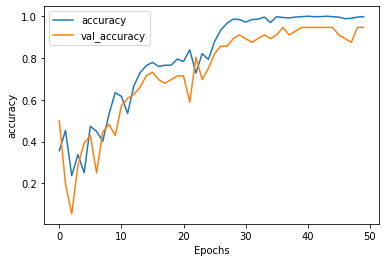

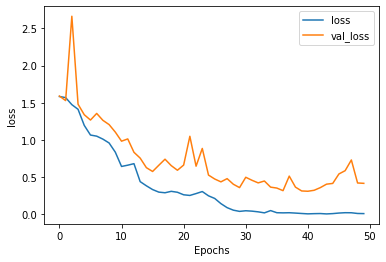

In [ ]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

Predicting with random user inputs 

In [ ]:

new_incident = ['When the electrician tried to turn on the electricity, he touched the metal box (called a breaker panel), and this made a flash that hurt him. He collapsed immediately and later was rushed to the hospital.']
seq = tokenizer.texts_to_sequences(new_incident)
padded = pad_sequences(seq, maxlen=200)
pred = model_LSTM.predict(padded)
labels = [1,2,3,4,5]
print(" The predicted label of the same text is {}".format(labels[np.argmax(pred)]))

 The predicted label of the same text is 2


Testing Performance metric with Test Data

In [ ]:
data_validation["Accident Level"].value_counts()

1    42
2    18
3    16
4    14
5     9
Name: Accident Level, dtype: int64

In [51]:
X_test = tokenizer.texts_to_sequences(data_validation['Combined_text'].values)
X_test = pad_sequences(X_test, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X_test.shape)

Shape of data tensor: (99, 250)


In [55]:
y_test = (data_validation['Accident Level'])

In [ ]:
Y_Pred = model_LSTM.predict(X_test)

In [ ]:
type(y_test)

pandas.core.series.Series

In [ ]:
Y_Pred = Y_Pred.tolist()

In [ ]:
labels = [1,2,3,4,5]
Y_pred_arr = []
for item in Y_Pred:
  Y_pred_arr.append(labels[np.argmax(item)])

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, Y_pred_arr))


              precision    recall  f1-score   support

           1       0.90      0.88      0.89        42
           2       0.76      0.89      0.82        18
           3       1.00      0.81      0.90        16
           4       0.87      0.93      0.90        14
           5       1.00      1.00      1.00         9

    accuracy                           0.89        99
   macro avg       0.91      0.90      0.90        99
weighted avg       0.90      0.89      0.89        99



In [26]:
data_raw = pd.read_csv("/content/drive/MyDrive/Data for Capstone/DataRaw.csv")

In [27]:
data_raw.head()

,Unnamed: 0,Data,Countries,Local,Industry Sector,Accident Level,Potential Accident Level,Genre,Employee or Third Party,Critical Risk,Description
0,0,2016-01-01 00:00:00,Country_01,Local_01,Mining,I,IV,Male,Third Party,Pressed,While removing the drill rod of the Jumbo 08 f...
1,1,2016-01-02 00:00:00,Country_02,Local_02,Mining,I,IV,Male,Employee,Pressurized Systems,During the activation of a sodium sulphide pum...
2,2,2016-01-06 00:00:00,Country_01,Local_03,Mining,I,III,Male,Third Party (Remote),Manual Tools,In the sub-station MILPO located at level +170...
3,3,2016-01-08 00:00:00,Country_01,Local_04,Mining,I,I,Male,Third Party,Others,Being 9:45 am. approximately in the Nv. 1880 C...
4,4,2016-01-10 00:00:00,Country_01,Local_04,Mining,IV,IV,Male,Third Party,Others,Approximately at 11:45 a.m. in circumstances t...


In [28]:
data_raw = data_raw.drop(columns=["Unnamed: 0","Critical Risk"],axis =1)

In [29]:
data_raw['Date'] = pd.to_datetime(data_raw['Data']) #Converting the date column to date type leaving out the time component
data_raw['Year'] = data_raw['Date'].apply(lambda x : x.year)
data_raw['Month'] = data_raw['Date'].apply(lambda x : x.month)
data_raw['Day'] = data_raw['Date'].apply(lambda x : x.day)
data_raw['Weekday'] = data_raw['Date'].apply(lambda x : x.dayofweek)
data_raw['WeekofYear'] = data_raw['Date'].apply(lambda x : x.weekofyear)

In [30]:
data_raw["Combined_text"] = ""
for row in range(0,data_raw.shape[0]):
  data_raw["Combined_text"][row] = " The decription of the incident is {}. The incident happned in {} and {} area. The industry is {}. The potential level was {}. This was reported by a {}. The affected party was a {}. The year was {}. The month was {}. the day was {}".format(data_raw["Description"][row],data_raw["Countries"][row],data_raw["Local"][row],data_raw["Industry Sector"][row],data_raw["Potential Accident Level"][row],data_raw["Genre"][row],data_raw["Employee or Third Party"][row],data_raw["Year"][row],data_raw["Month"][row],data_raw["Day"][row])

In [31]:
data_raw.head()

,Data,Countries,Local,Industry Sector,Accident Level,Potential Accident Level,Genre,Employee or Third Party,Description,Date,Year,Month,Day,Weekday,WeekofYear,Combined_text
0,2016-01-01 00:00:00,Country_01,Local_01,Mining,I,IV,Male,Third Party,While removing the drill rod of the Jumbo 08 f...,2016-01-01,2016,1,1,4,53,The decription of the incident is While remov...
1,2016-01-02 00:00:00,Country_02,Local_02,Mining,I,IV,Male,Employee,During the activation of a sodium sulphide pum...,2016-01-02,2016,1,2,5,53,The decription of the incident is During the ...
2,2016-01-06 00:00:00,Country_01,Local_03,Mining,I,III,Male,Third Party (Remote),In the sub-station MILPO located at level +170...,2016-01-06,2016,1,6,2,1,The decription of the incident is In the sub-...
3,2016-01-08 00:00:00,Country_01,Local_04,Mining,I,I,Male,Third Party,Being 9:45 am. approximately in the Nv. 1880 C...,2016-01-08,2016,1,8,4,1,The decription of the incident is Being 9:45 ...
4,2016-01-10 00:00:00,Country_01,Local_04,Mining,IV,IV,Male,Third Party,Approximately at 11:45 a.m. in circumstances t...,2016-01-10,2016,1,10,6,1,The decription of the incident is Approximate...


In [32]:
data_raw = data_raw.drop(columns=["Data","Countries","Local","Industry Sector","Potential Accident Level","Genre","Employee or Third Party","Description","Date","Year","Month","Day","Weekday","WeekofYear"],axis =1)

In [33]:
data_raw.head()

,Accident Level,Combined_text
0,I,The decription of the incident is While remov...
1,I,The decription of the incident is During the ...
2,I,The decription of the incident is In the sub-...
3,I,The decription of the incident is Being 9:45 ...
4,IV,The decription of the incident is Approximate...


In [34]:
data_raw["Accident Level"]= data_raw['Accident Level'].astype('category')

In [35]:
data_raw.head()

,Accident Level,Combined_text
0,I,The decription of the incident is While remov...
1,I,The decription of the incident is During the ...
2,I,The decription of the incident is In the sub-...
3,I,The decription of the incident is Being 9:45 ...
4,IV,The decription of the incident is Approximate...


In [36]:
# Update values in the target variable
def convertRomanToNumerical(number):
  if number == '':
    return 0
  elif number == 'I':
    return 1
  elif number == 'II':
    return 2
  elif number == 'III':
    return 3
  elif number == 'IV':
    return 4
  elif number == 'V':
    return 5
  elif number == 'VI':
    return 6
  else:
    return 0



In [37]:
data_raw['Accident Level'] = data_raw['Accident Level'].apply(convertRomanToNumerical)

In [38]:
data_raw.head()

,Accident Level,Combined_text
0,1,The decription of the incident is While remov...
1,1,The decription of the incident is During the ...
2,1,The decription of the incident is In the sub-...
3,1,The decription of the incident is Being 9:45 ...
4,4,The decription of the incident is Approximate...


In [39]:
clean_balanced_headlines = []
for headline in data_raw['Combined_text']:
  clean_balanced_headlines.append(clean_text(headline, remove_stopwords = True))
print('Data is cleaned!')

Data is cleaned!


In [40]:
data_raw['Combined_text'] = clean_balanced_headlines
data_raw.head()

,Accident Level,Combined_text
0,1,decription incident removing drill rod jumbo 0...
1,1,decription incident activation sodium sulphide...
2,1,decription incident sub station milpo located ...
3,1,decription incident 9 45 approximately nv 1880...
4,4,decription incident approximately 11 45 circum...


In [41]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(data_raw['Combined_text'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 3339 unique tokens.


In [42]:
data_raw = data_raw.sample(frac=1).reset_index(drop=True) # Shuffling the dataset before building model

In [43]:
train_size = int(len(data_raw) * training_portion)

data_raw_train = data_raw.head(train_size)
data_raw_validation = data_raw.tail(len(data)-train_size)

print(len(data_raw_train))
print(len(data_raw_validation))
print(len(data_raw))

361
297
425


In [44]:
X_raw = tokenizer.texts_to_sequences(data_raw_train['Combined_text'].values)
X_raw = pad_sequences(X_raw, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X_raw.shape)

Shape of data tensor: (361, 250)


In [45]:
Y_raw = pd.get_dummies(data_raw_train['Accident Level']).values
print('Shape of label tensor:', Y_raw.shape)
print(Y_raw)

Shape of label tensor: (361, 5)
[[1 0 0 0 0]
 [1 0 0 0 0]
 [1 0 0 0 0]
 ...
 [1 0 0 0 0]
 [1 0 0 0 0]
 [1 0 0 0 0]]


In [ ]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', np.unique(data['Accident Level'].values), data['Accident Level'].values)
weight = {i : class_weights[i] for i in range(5)}
print(weight)

epochs = 50
batch_size = 32

history = model_LSTM.fit(X_raw, Y_raw, class_weight=weight, epochs=epochs, batch_size=batch_size,validation_split=0.1)

{0: 0.41645569620253164, 1: 1.1855855855855857, 2: 1.3708333333333333, 3: 1.4786516853932585, 4: 2.860869565217391}
Epoch 1/50
11/11 [==============================] - 11s 1s/step - loss: 1.9010 - accuracy: 0.4259 - val_loss: 1.4899 - val_accuracy: 0.1892
Epoch 2/50
11/11 [==============================] - 11s 1s/step - loss: 1.0025 - accuracy: 0.5309 - val_loss: 1.2581 - val_accuracy: 0.6216
Epoch 3/50
11/11 [==============================] - 11s 1s/step - loss: 0.9353 - accuracy: 0.7160 - val_loss: 1.1658 - val_accuracy: 0.7027
Epoch 4/50
11/11 [==============================] - 11s 1s/step - loss: 0.9054 - accuracy: 0.7315 - val_loss: 1.2010 - val_accuracy: 0.7027
Epoch 5/50
11/11 [==============================] - 11s 1s/step - loss: 0.8620 - accuracy: 0.7377 - val_loss: 1.1738 - val_accuracy: 0.7027
Epoch 6/50
11/11 [==============================] - 11s 1s/step - loss: 0.8297 - accuracy: 0.7346 - val_loss: 1.1668 - val_accuracy: 0.6757
Epoch 7/50
11/11 [==========================

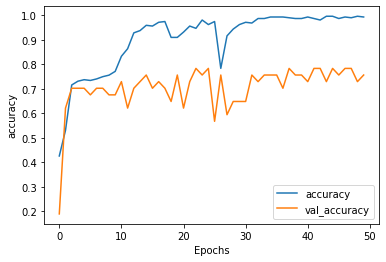

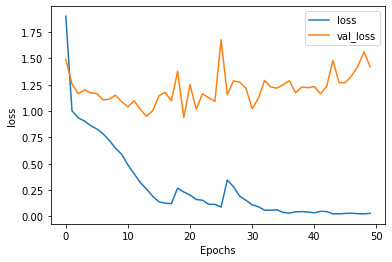

In [ ]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:

new_incident = ['When the electrician tried to turn on the electricity, he touched the metal box (called a breaker panel), and this made a flash that hurt him. He collapsed immediately and later was rushed to the hospital.']
seq = tokenizer.texts_to_sequences(new_incident)
padded = pad_sequences(seq, maxlen=200)
pred = model_LSTM.predict(padded)
labels = [1,2,3,4,5]
print(" The predicted label of the same text is {}".format(labels[np.argmax(pred)]))

 The predicted label of the same text is 3


In [ ]:
data_raw_validation["Accident Level"].value_counts()

1    223
2     27
3     23
4     16
5      8
Name: Accident Level, dtype: int64

In [ ]:
X_test_raw = tokenizer.texts_to_sequences(data_raw_validation['Combined_text'].values)
X_test_raw = pad_sequences(X_test_raw, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X_test_raw.shape)

Shape of data tensor: (297, 250)


In [ ]:
y_test_raw = (data_raw_validation['Accident Level'])

In [ ]:
Y_Pred_raw = model_LSTM.predict(X_test_raw)

In [ ]:
Y_Pred_raw = Y_Pred_raw.tolist()

In [ ]:
labels = [1,2,3,4,5]
Y_pred_arr_raw = []
for item in Y_Pred_raw:
  Y_pred_arr_raw.append(labels[np.argmax(item)])

In [ ]:
# Classficition report for LSTM without data augmenttion
from sklearn.metrics import classification_report

print(classification_report(Y_pred_arr_raw, y_test_raw))


              precision    recall  f1-score   support

           1       0.95      0.93      0.94       229
           2       0.74      0.71      0.73        28
           3       0.83      0.79      0.81        24
           4       0.69      1.00      0.81        11
           5       0.62      1.00      0.77         5

    accuracy                           0.90       297
   macro avg       0.77      0.89      0.81       297
weighted avg       0.91      0.90      0.90       297



In [ ]:
# Classficition report for LSTM with data augmentation
from sklearn.metrics import classification_report

print(classification_report(y_test, Y_pred_arr))

              precision    recall  f1-score   support

           1       0.90      0.88      0.89        42
           2       0.76      0.89      0.82        18
           3       1.00      0.81      0.90        16
           4       0.87      0.93      0.90        14
           5       1.00      1.00      1.00         9

    accuracy                           0.89        99
   macro avg       0.91      0.90      0.90        99
weighted avg       0.90      0.89      0.89        99



Building Bi_Directional LSTM Models 

BiDirectional LSTM Model on Augmented data 

In [46]:
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
model_bidirectional = Sequential()
model_bidirectional.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model_bidirectional.add(SpatialDropout1D(0.2))
model_bidirectional.add(Bidirectional(LSTM(EMBEDDING_DIM, dropout=0.3, recurrent_dropout=0.3)))
model_bidirectional.add(Dense(5, activation='softmax'))
model_bidirectional.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model_bidirectional.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 250, 100)          5000000   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 250, 100)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 200)               160800    
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 1005      
Total params: 5,161,805
Trainable params: 5,161,805
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', np.unique(data['Accident Level'].values), data['Accident Level'].values)
weight = {i : class_weights[i] for i in range(5)}
print(weight)

epochs = 50
batch_size = 32

history = model_bidirectional.fit(X, Y, class_weight=weight, epochs=epochs, batch_size=batch_size,validation_split=0.1)

{0: 0.41645569620253164, 1: 1.1855855855855857, 2: 1.3708333333333333, 3: 1.4786516853932585, 4: 2.860869565217391}
Epoch 1/50
16/16 [==============================] - 32s 2s/step - loss: 0.5563 - accuracy: 0.6799 - val_loss: 0.9172 - val_accuracy: 0.6786
Epoch 2/50
16/16 [==============================] - 32s 2s/step - loss: 0.4871 - accuracy: 0.7654 - val_loss: 1.4179 - val_accuracy: 0.5179
Epoch 3/50
16/16 [==============================] - 32s 2s/step - loss: 0.4036 - accuracy: 0.7873 - val_loss: 1.1369 - val_accuracy: 0.5357
Epoch 4/50
16/16 [==============================] - 32s 2s/step - loss: 0.3596 - accuracy: 0.7893 - val_loss: 1.1068 - val_accuracy: 0.5357
Epoch 5/50
16/16 [==============================] - 32s 2s/step - loss: 0.3026 - accuracy: 0.8429 - val_loss: 0.9084 - val_accuracy: 0.6250
Epoch 6/50
16/16 [==============================] - 32s 2s/step - loss: 0.1871 - accuracy: 0.9085 - val_loss: 0.8578 - val_accuracy: 0.7321
Epoch 7/50
16/16 [==========================

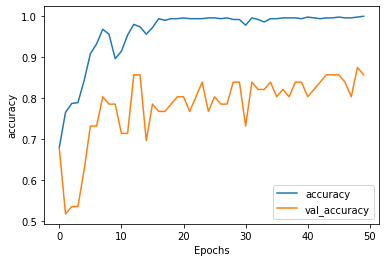

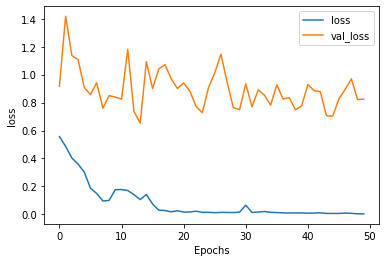

In [ ]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:

new_incident = ['When the electrician tried to turn on the electricity, he touched the metal box (called a breaker panel), and this made a flash that hurt him. He collapsed immediately and later was rushed to the hospital.']
seq = tokenizer.texts_to_sequences(new_incident)
padded = pad_sequences(seq, maxlen=200)
pred = model_bidirectional.predict(padded)
labels = [1,2,3,4,5]
print(" The predicted label of the same text is {}".format(labels[np.argmax(pred)]))

 The predicted label of the same text is 1


In [ ]:
Y_Pred_bi_aug = model_bidirectional.predict(X_test)

In [ ]:
Y_Pred_bi_aug = Y_Pred_bi_aug.tolist()

In [ ]:
labels = [1,2,3,4,5]
Y_Pred_bi_aug_arr = []
for item in Y_Pred_bi_aug:
  Y_Pred_bi_aug_arr.append(labels[np.argmax(item)])

In [ ]:
# Classficition report for LSTM with data augmentation
from sklearn.metrics import classification_report

print(classification_report(y_test, Y_Pred_bi_aug_arr))

              precision    recall  f1-score   support

           1       0.90      0.88      0.89        42
           2       0.73      0.89      0.80        18
           3       1.00      0.88      0.93        16
           4       1.00      0.93      0.96        14
           5       1.00      1.00      1.00         9

    accuracy                           0.90        99
   macro avg       0.93      0.91      0.92        99
weighted avg       0.91      0.90      0.90        99



BiDirectional LSTM Model on Raw Data

In [ ]:
class_weights = class_weight.compute_class_weight('balanced', np.unique(data['Accident Level'].values), data['Accident Level'].values)
weight = {i : class_weights[i] for i in range(5)}
print(weight)

epochs = 50
batch_size = 32

history = model_bidirectional.fit(X_raw, Y_raw, class_weight=weight, epochs=epochs, batch_size=batch_size,validation_split=0.1)

{0: 0.41645569620253164, 1: 1.1855855855855857, 2: 1.3708333333333333, 3: 1.4786516853932585, 4: 2.860869565217391}
Epoch 1/50
11/11 [==============================] - 21s 2s/step - loss: 2.1252 - accuracy: 0.5401 - val_loss: 1.1977 - val_accuracy: 0.6216
Epoch 2/50
11/11 [==============================] - 21s 2s/step - loss: 1.0296 - accuracy: 0.4444 - val_loss: 1.3717 - val_accuracy: 0.4324
Epoch 3/50
11/11 [==============================] - 21s 2s/step - loss: 0.9460 - accuracy: 0.6574 - val_loss: 1.1550 - val_accuracy: 0.7027
Epoch 4/50
11/11 [==============================] - 21s 2s/step - loss: 0.9150 - accuracy: 0.7346 - val_loss: 1.1092 - val_accuracy: 0.7027
Epoch 5/50
11/11 [==============================] - 21s 2s/step - loss: 0.9258 - accuracy: 0.7253 - val_loss: 1.1299 - val_accuracy: 0.7027
Epoch 6/50
11/11 [==============================] - 21s 2s/step - loss: 0.8549 - accuracy: 0.7407 - val_loss: 1.0533 - val_accuracy: 0.7027
Epoch 7/50
11/11 [==========================

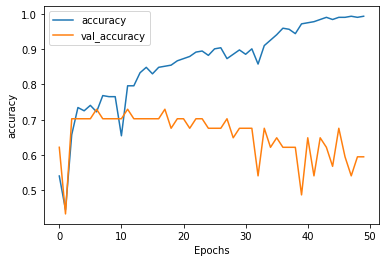

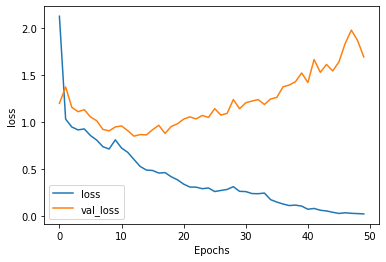

In [ ]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:

new_incident = ['When the electrician tried to turn on the electricity, he touched the metal box (called a breaker panel), and this made a flash that hurt him. He collapsed immediately and later was rushed to the hospital.']
seq = tokenizer.texts_to_sequences(new_incident)
padded = pad_sequences(seq, maxlen=200)
pred = model_bidirectional.predict(padded)
labels = [1,2,3,4,5]
print(" The predicted label of the same text is {}".format(labels[np.argmax(pred)]))

 The predicted label of the same text is 1


In [ ]:
Y_Pred_bi_raw = model_bidirectional.predict(X_test_raw)

In [ ]:
Y_Pred_bi_raw = Y_Pred_bi_raw.tolist()

In [ ]:
labels = [1,2,3,4,5]
Y_Pred_bi_raw_arr = []
for item in Y_Pred_bi_raw:
  Y_Pred_bi_raw_arr.append(labels[np.argmax(item)])

In [ ]:
# Classficition report for LSTM with data augmentation
from sklearn.metrics import classification_report

print(classification_report(y_test_raw, Y_Pred_bi_raw_arr))

              precision    recall  f1-score   support

           1       0.94      0.91      0.92       223
           2       0.53      0.85      0.66        27
           3       0.80      0.70      0.74        23
           4       0.92      0.75      0.83        16
           5       0.71      0.62      0.67         8

    accuracy                           0.87       297
   macro avg       0.78      0.77      0.76       297
weighted avg       0.89      0.87      0.87       297



Observation: <br>

-> The data was uploaded, processed and transformed for LSTM model development <br> 

-> LSTM and RNN models were built on top of raw data and augmented data <br> 

-> The comparision of the various models have been listed below  <br> 

-> This is a clear indictaion that the models without data augmentation tends to mark all records as class 1 which is corrected in the model built with augmentaed data <br> 

-> I tried various number of epochs and data split to identify an optimal accuracay <br> 



| Model                                           | Accuracy  |
|-------------------------------------------------|-----------|
| LSTM with Augmented Data                        | .89       |
| LSTM with Raw Data                              | .90       |
| BiDirectional LSTM ( RNN ) with Augmented data  | .90       |
| BiDirectional LSTM ( RNN ) with Raw data        | .87       |

| Model                                          | Class | Precision | Recall | F1 Score  | Support |
|------------------------------------------------|-------|-----------|--------|-----------|---------|
| LSTM with Augmented Data                       | 1     | 0.90      | 0.88   | .89       | 42      |
| LSTM with Augmented Data                       | 2     | 0.76      | 0.89   | 0.82      | 18      |
| LSTM with Augmented Data                       | 3     | 1.00      | 0.81   | 0.90      | 16      |
| LSTM with Augmented Data                       | 4     | 0.87      | 0.93   | 0.90      | 14      |
| LSTM with Augmented Data                       | 5     | 1.00      | 1.00   | 1.00      | 9       |
| LSTM with Raw Data                             | 1     | 0.95      | 0.93   | 0.94      | 22      |
| LSTM with Raw Data                             | 2     | 0.74      | 0.71   | 0.73      | 28      |
| LSTM with Raw Data                             | 3     | 0.83      | 0.79   | 0.81      | 24      |
| LSTM with Raw Data                             | 4     | 0.69      | 1.00   | 0.81      | 11      |
| LSTM with Raw Data                             | 5     | 0.62      | 1.00   | 0.77      | 5       |
| BiDirectional LSTM ( RNN ) with Augmented data | 1     | 0.90      | 0.88   | 0.89      | 42      |
| BiDirectional LSTM ( RNN ) with Augmented data | 2     | 0.73      | 0.89   | 0.80      | 18      |
| BiDirectional LSTM ( RNN ) with Augmented data | 3     | 1.00      | 0.88   | 0.93      | 16      |
| BiDirectional LSTM ( RNN ) with Augmented data | 4     | 1.00      | 0.93   | 0.96      | 14      |
| BiDirectional LSTM ( RNN ) with Augmented data | 5     | 1.00      | 1.00   | 1.00      | 9       |
| BiDirectional LSTM ( RNN ) with Raw data       | 1     | 0.94      | 0.91   | 0.92      | 223     |
| BiDirectional LSTM ( RNN ) with Raw data       | 2     | 0.53      | 0.85   | 0.66      | 27      |
| BiDirectional LSTM ( RNN ) with Raw data       | 3     | 0.80      | 0.70   | 0.74      | 23      |
| BiDirectional LSTM ( RNN ) with Raw data       | 4     | 0.92      | 0.75   | 0.83      | 16      |
| BiDirectional LSTM ( RNN ) with Raw data       | 5     | 0.71      | 0.62   | 0.67      | 8       |

Observation: 

-> While LSTM with raw data has high accuracy, the classes do not have good performance scores<br>

-> Its critical to get the high risk classes correct, so that correct actions can be taken<br>

-> In that perspective the bi-directional LSTM seems like the best model

In [47]:
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
model_bidirectional_augmented = Sequential()
model_bidirectional_augmented.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model_bidirectional_augmented.add(SpatialDropout1D(0.1)) # Changing dropout percentage
model_bidirectional_augmented.add(Bidirectional(LSTM(EMBEDDING_DIM, dropout=0.2, recurrent_dropout=0.2))) #changing dropout percentage 
model_bidirectional_augmented.add(Dense(24, activation='relu')) # Adding another dense layer
model_bidirectional_augmented.add(Dense(5, activation='softmax'))
model_bidirectional_augmented.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model_bidirectional_augmented.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 250, 100)          5000000   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 250, 100)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200)               160800    
_________________________________________________________________
dense_2 (Dense)              (None, 24)                4824      
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 125       
Total params: 5,165,749
Trainable params: 5,165,749
Non-trainable params: 0
_________________________________________________________________
None


In [48]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', np.unique(data['Accident Level'].values), data['Accident Level'].values)
weight = {i : class_weights[i] for i in range(5)}
print(weight)

epochs = 50 # Changing number of epochs
batch_size = 24 # changing batch size 

history = model_bidirectional_augmented.fit(X, Y, class_weight=weight, epochs=epochs, batch_size=batch_size,validation_split=0.1)

{0: 0.41645569620253164, 1: 1.1855855855855857, 2: 1.3708333333333333, 3: 1.4786516853932585, 4: 2.860869565217391}
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/50
21/21 [==============================] - 78s 2s/step - loss: 1.6260 - accuracy: 0.2139 - val_loss: 1.6019 - val_accuracy: 0.1071
Epoch 2/50
21/21 [==============================] - 43s 2s/step - loss: 1.6217 - accuracy: 0.1549 - val_loss: 1.5840 - val_accuracy: 0.1607
Epoch 3/50
21/21 [==============================] - 43s 2s/step - loss: 1.4447 - accuracy: 0.1828 - val_loss: 1.3001 - val_accuracy: 0.5893
Epoch 4/50
21/21 [==============================] - 44s 2s/step - loss: 1.1307 - accuracy: 0.4885 - val_loss: 1.3392 - val_accuracy: 0.3571
Epoch 5/50
21/21 [==============================] - 43s 2s/step - loss: 0.8398 - accuracy: 0.6963 - val_loss: 1.3935 - val_accuracy: 0.4286
Epoch 6/50
21/21 [============================

In [49]:

new_incident = ['When the electrician tried to turn on the electricity, he touched the metal box (called a breaker panel), and this made a flash that hurt him. He collapsed immediately and later was rushed to the hospital.']
seq = tokenizer.texts_to_sequences(new_incident)
padded = pad_sequences(seq, maxlen=200)
pred = model_bidirectional_augmented.predict(padded)
labels = [1,2,3,4,5]
print(" The predicted label of the same text is {}".format(labels[np.argmax(pred)]))

 The predicted label of the same text is 5


In [52]:
Y_Pred_bi_aug = model_bidirectional_augmented.predict(X_test)
Y_Pred_bi_aug = Y_Pred_bi_aug.tolist()

In [53]:
labels = [1,2,3,4,5]
Y_Pred_bi_aug_arr = []
for item in Y_Pred_bi_aug:
  Y_Pred_bi_aug_arr.append(labels[np.argmax(item)])

In [56]:
# Classficition report for LSTM with data augmentation
from sklearn.metrics import classification_report

print(classification_report(y_test, Y_Pred_bi_aug_arr))

              precision    recall  f1-score   support

           1       0.43      0.28      0.34        46
           2       0.08      0.18      0.11        11
           3       0.00      0.00      0.00        17
           4       0.16      0.33      0.21        15
           5       0.00      0.00      0.00        10

    accuracy                           0.20        99
   macro avg       0.13      0.16      0.13        99
weighted avg       0.23      0.20      0.20        99



Observations:

*   The hyper parameter tuning has not helped in the accuracy metrics for the model
*   The various types of hyper paramters that were tuned were <br>
1) Structure of the model <br>
2) number of batches <br>
3) number of epochs <br>
*   The Bidirectional LSTM model was used for the chatbot 



